In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
factorial = np.math.factorial
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

import matplotlib.pyplot as plt

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform # isoprobabilistic transform

# custom module
import Surrogates.PolynomialChaosExpansion as PCE

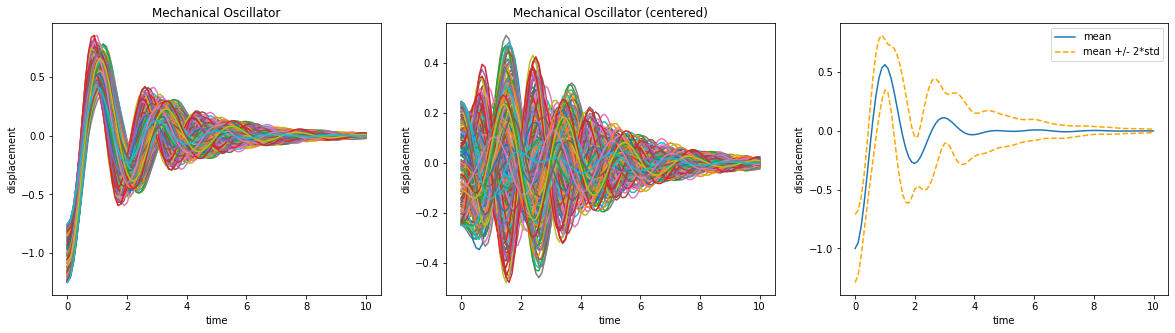

In [7]:
N = 20_000 # number of 'instances'/'realisations'
n_t = 100
t = np.linspace(0, 10, n_t+1) # row vector
T = np.tile(t, (N, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(N) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [n, N_quad]

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')
ax[0].set_title('Mechanical Oscillator')

for i in np.arange(200):
    ax[1].plot(t,Y_c[i,:], '-')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].set_title('Mechanical Oscillator (centered)')

'Plot the mean and 2 stds of random process'
ax[2].plot(t,Y_mean, '-', label = 'mean')
ax[2].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[2].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[2].set_ylabel('displacement')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

In [4]:
total_polynomial_degree = 2

number_of_random_variables = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform)

PCE_t_i.print_combinations()

first_order_index_coefficient_picker, total_index_coefficient_picker = PCE_t_i.coefficient_pickers()

print(first_order_index_coefficient_picker)
print(total_index_coefficient_picker)

Number of polynomial terms: 10
Sum = 1 : {(1, 0, 0), (0, 1, 0), (0, 0, 1)} 

Sum = 2 : {(1, 1, 0), (0, 1, 1), (0, 2, 0), (0, 0, 2), (2, 0, 0), (1, 0, 1)} 

[[0 0 0 0 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0]]
[[0 1 0 0 0 1 0 1 0 1]
 [0 1 1 1 0 0 0 0 1 0]
 [0 0 1 0 1 0 1 1 0 0]]


# PCE Surrogate

In [5]:
total_polynomial_degree = 8

number_of_random_variables = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform)

# Points where PCE surrogates must be constructed
inspection_points = 51
I = np.linspace(0 , n_t, inspection_points, dtype=int)

# store LOO error
LOO_error = np.zeros((inspection_points, 1))

# store variance
store_variance = np.zeros((inspection_points, 1))

print(f"Number of PCE terms: {PCE_t_i.number_of_PCE_terms}")
print(f"Number of evaluations needed (empirical estimate): {(number_of_random_variables - 1)*PCE_t_i.number_of_PCE_terms}") # (M-1)*P [Sudret]
print(f"Number of function evaluations: {N}") 

for j, time_index in enumerate(tqdm(I, desc = 'Computing PCE surrogates', ncols=100)):

    X_hat = SampleSpace
    Y_hat = Y[:, time_index]

    _ = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # store variance at each t_i
    product_beta = PCE_t_i.beta**2
    store_variance[j] = np.sum(product_beta[1:])

Number of PCE terms: 165
Number of evaluations needed (empirical estimate): 330
Number of function evaluations: 20000


Computing PCE surrogates: 100%|█████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


# LOO Error

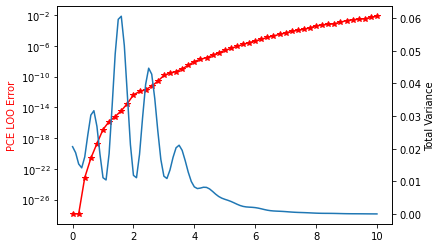

In [9]:
fig, ax = plt.subplots()

ax.semilogy(t[I], LOO_error,  '-*', color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

ax2 = ax.twinx()
ax2.plot(t, np.var(Y, axis=0), '-', label = 'Total Variance')
ax2.set_ylabel("Total Variance")

plt.show()

In [7]:
total_polynomial_degree = 6

number_of_random_variables = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform)

# Points where PCE surrogates must be constructed
inspection_points = 51
I = np.linspace(0 , n_t, inspection_points, dtype=int)

# store LOO error
LOO_error_2 = np.zeros((inspection_points, 1))

# store variance
store_variance_2 = np.zeros((inspection_points, 1))

print(f"Number of PCE terms: {PCE_t_i.number_of_PCE_terms}")
print(f"Number of evaluations needed (empirical estimate): {(number_of_random_variables - 1)*PCE_t_i.number_of_PCE_terms}") # (M-1)*P [Sudret]
print(f"Number of function evaluations: {N}") 

for j, time_index in enumerate(tqdm(I, desc = 'Computing PCE surrogates', ncols=100)):

    X_hat = SampleSpace
    Y_hat = Y[:, time_index]

    _ = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error_2[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # store variance at each t_i
    product_beta = PCE_t_i.beta**2
    store_variance_2[j] = np.sum(product_beta[1:])

Computing PCE surrogates:   0%|                                              | 0/51 [00:00<?, ?it/s]

Number of PCE terms: 84
Number of evaluations needed (empirical estimate): 168
Number of function evaluations: 20000


Computing PCE surrogates: 100%|█████████████████████████████████████| 51/51 [01:04<00:00,  1.27s/it]


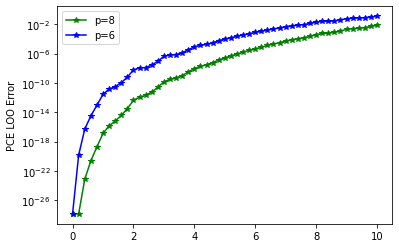

In [8]:
fig, ax = plt.subplots()

ax.semilogy(t[I], LOO_error,  '-*', color = 'green', label = 'p=8')
ax.semilogy(t[I], LOO_error_2,  '-*', color = 'blue', label = 'p=6')
ax.set_ylabel("PCE LOO Error")
plt.legend()

plt.show()